In [24]:
import sys
sys.path.append("../")
import settings
from tqdm import tqdm
import json
import os
from process_sentinel2 import Mask, DayDataGenerator, DayData
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from clustering import ClusteringProcessing
%matplotlib inline

In [2]:
def draw_text(text,img, x , y, color = (255,255,255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (110, 25)
    fontScale = 1
    thickness = 2
    cv2.putText(img, text, (x, y), font, 1, color, thickness, cv2.LINE_AA)

### Define variables

In [3]:
RAW_DATA_PATH = settings.raw_data_path
PROCESSED_DATA_PATH = settings.processed_data_path
DATE_FORMAT = '%Y-%m-%d'

START_DATE = '2016-01-04'
END_DATE = '2021-03-26'
#END_DATE_NEW = '2022-04-20'

#START_DATE = '2018-11-01'
#END_DATE = '2022-05-01'

MASK_DIRECTORY_PATH = settings.water_mask_path

TA_coords = [(-34.829637, -55.042053)]

In [4]:
cisne_coords = [(-34.840706,-55.124542),
                (-34.840874,-55.124161),
                (-34.840958,-55.123714),
                (-34.841045,-55.123295),
                (-34.841148,-55.122890),
                (-34.841213,-55.122463),
                (-34.841267,-55.122021),
                (-34.841263,-55.121574),
                (-34.841316,-55.121098),
                (-34.841351,-55.120655),
                (-34.841373,-55.120228),
                (-34.841446,-55.119766),
                (-34.841412,-55.119339),
                (-34.841366,-55.118900),
                (-34.841270,-55.118450),
                (-34.841190,-55.117992),
                (-34.841217,-55.117546),
                (-34.841038,-55.117142),
                (-34.840878,-55.116745),
                (-34.840683,-55.116371),
                (-34.840454,-55.116020),
                (-34.840191,-55.115730),
                (-34.839989,-55.115360),
                (-34.839691,-55.115154),
                (-34.841896,-55.124554),
                (-34.842670,-55.124363),
                (-34.843388,-55.124084),
                (-34.844120,-55.123917),
                (-34.844803,-55.123581),
                (-34.845470,-55.123329),
                (-34.845757,-55.122528),
                (-34.846046,-55.121731),
                (-34.846363,-55.120941),
                (-34.846489,-55.120060),
                (-34.847328,-55.118622),
                (-34.848049,-55.118713),
                (-34.848778,-55.118721),
                (-34.848412,-55.117973),
                (-34.848007,-55.117233),
                (-34.848095,-55.116329),
                (-34.848179,-55.115429),
                (-34.848244,-55.114578),
                (-34.848476,-55.113739),
                (-34.848526,-55.112934),
                (-34.848301,-55.112099),
                (-34.847683,-55.111664),
                (-34.847027,-55.111271),
                (-34.846401,-55.110752),
                (-34.845741,-55.110382),
                (-34.844952,-55.110188),
                (-34.844261,-55.110210),
                (-34.843727,-55.110916),
                (-34.843151,-55.111576)]
print(len(cisne_coords))

53


### Make instance of data generator

In [5]:
data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, PROCESSED_DATA_PATH, skip_invalid=True)
len(data_generator)

92

### Load sample day

In [106]:
sample_day = DayData(os.path.join(settings.processed_data_path, "2020-03-23", "MSI"))

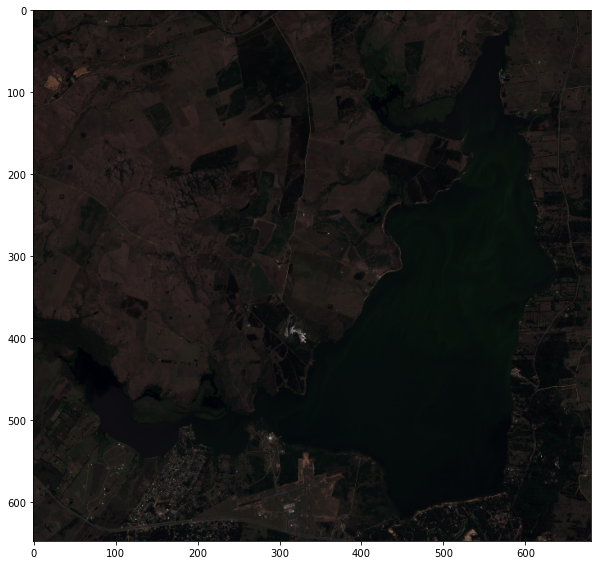

In [7]:
#sample_day.paint_coords(cisne_coords, (255, 255, 0), radius=1)
sample_day.show_rgb()
#plt.savefig("cisnes_sample_points.png", dpi=200, bbox_inches='tight')

### Load water mask

In [104]:
mask = Mask(MASK_DIRECTORY_PATH)
#mask.reduce_mask()

print("Pixel count:", mask.get_pixel_count())

Pixel count: 79726


### Display mask in sample day

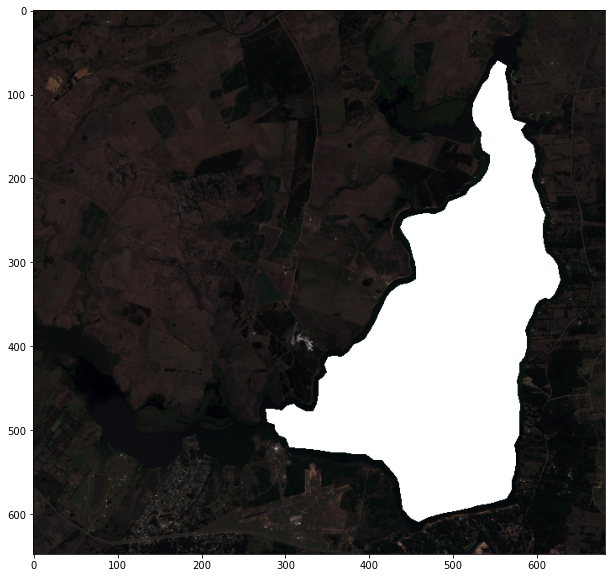

In [107]:
#sample_day = DayData(os.path.join(settings.data_path, "2020-05-30", "acolite_output"))
fig = plt.figure(figsize=(20,10))
#sample_day.paint_coords(cisne_coords, (0, 0, 255), radius=1)
rgb_with_mask = mask.display_mask_img(sample_day.rgb)
plt.imshow(rgb_with_mask)
#plt.savefig("cisnes_with_mask.png", dpi=200, bbox_inches='tight')
plt.show()

### Tag image cloudiness

levels of cloud:

0) Clear

1) minimum clouds over the lake

2) medium amount of clouds

3) too cloudy to be any good


In [10]:
# from IPython.display import clear_output
# import time
# START_DATE = '2018-11-01'
# END_DATE = '2022-05-01'
# data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, PROCESSED_DATA_PATH, tagging=True)
# retag = False

# for day in data_generator:
#     print(day.date)
#     print(day.metadata)
#     current_metadata = day.metadata
#     if current_metadata != {} and not retag:
#         time.sleep(0.1)
#         clear_output(wait=True)
#         continue
#     # display rgb of day
#     fig = plt.figure(figsize=(20,10))
#     plt.imshow(mask.display_mask_contour(day.rgb))
#     plt.show()
#     # get user input
#     user_input = input()
#     # overwrite with changes
#     with open(day.metadata_path, 'w') as fp:
#         current_metadata["cloud level"] = user_input
#         json.dump(current_metadata, fp)
#     clear_output(wait=True)

### Acquisition metrics

In [11]:
data_generator_all = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, PROCESSED_DATA_PATH, skip_invalid=False)
data_generator_valid = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, PROCESSED_DATA_PATH, skip_invalid=True)

print(f"Total dates: {len(data_generator_all)}")
print(f"Valid dates: {len(data_generator_valid)}")

Total dates: 286
Valid dates: 92


## Clustering

### Make NDCI numpy array dataset

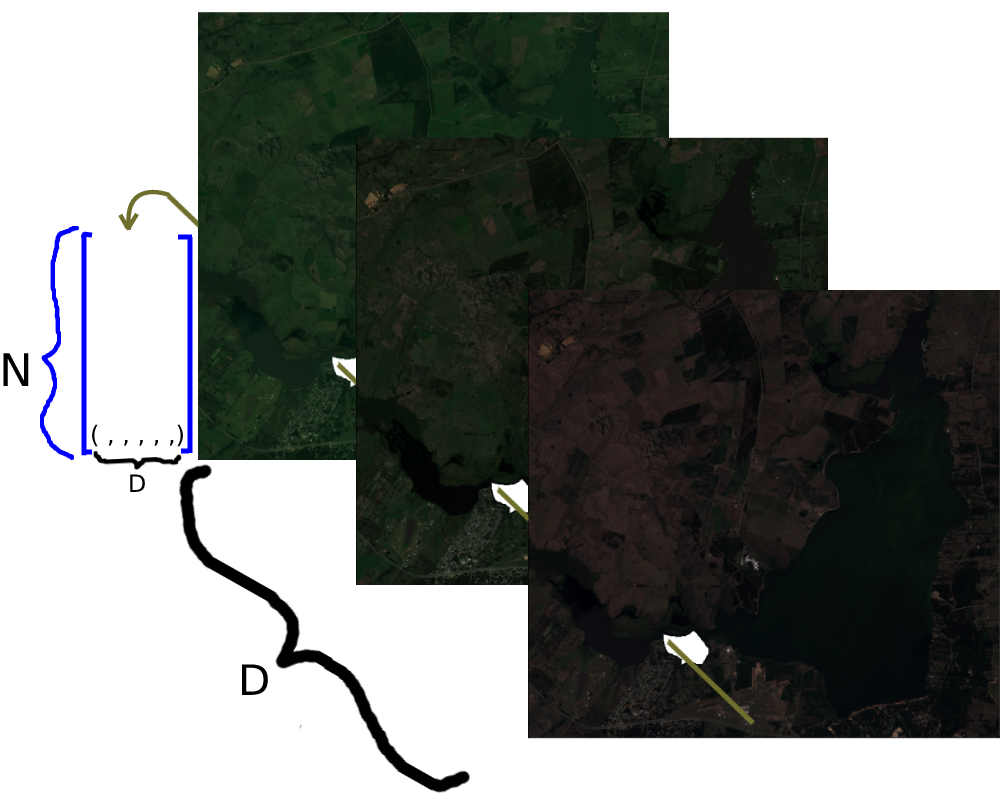

100%|██████████| 441288/441288 [00:00<00:00, 643110.80it/s]


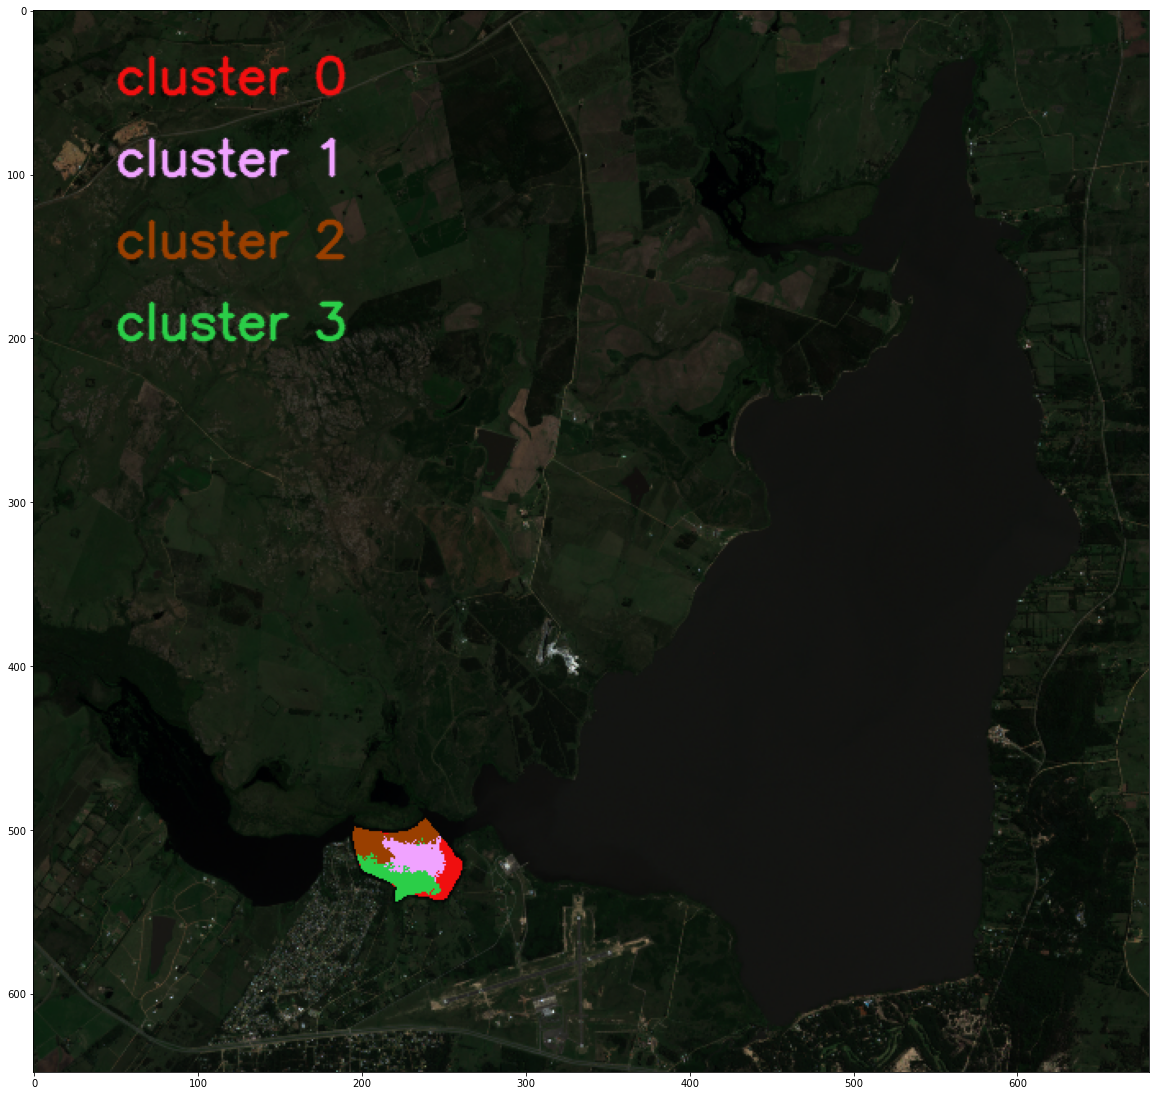

In [12]:
clustering_object = ClusteringProcessing(data_generator, mask, clustering_algorithm="kmeans", k_clusters=4)

clusters_image = clustering_object.make_clusters_image()

clusters_mask = clustering_object.make_clusters_mask()
    
fig = plt.figure(figsize=(20,20))
plt.imshow(clusters_image)

# Fit clustering data

In [13]:
#X = np.array(clustering_data["data"])
X = clustering_object.dataset["data"]

### K-means

100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

[213.83321365615964, 189.61571518348327, 177.02765670038107, 167.98979142448047, 161.34251966758634, 155.33888388625195]


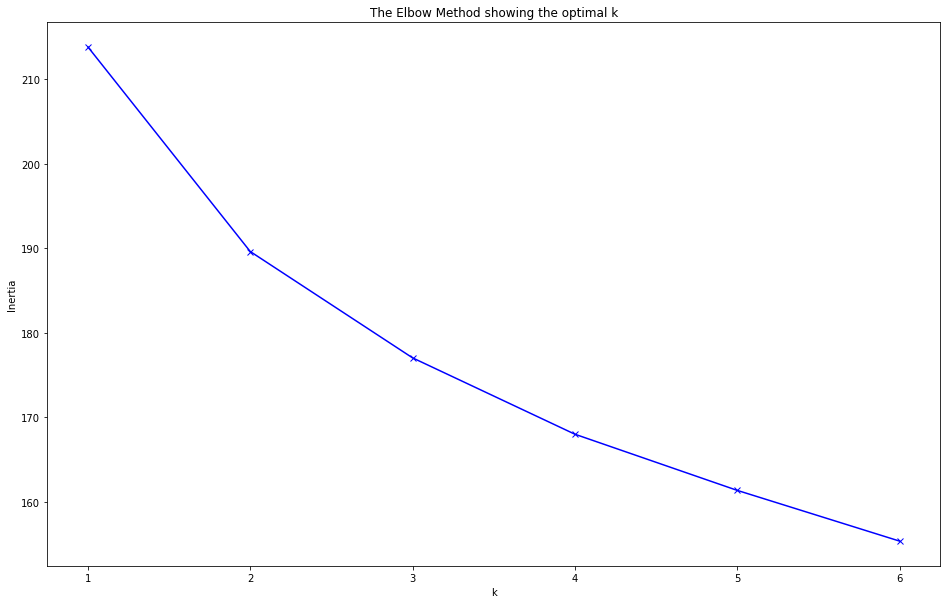

In [14]:
from sklearn.cluster import KMeans


kmeans_save_path = "K-means"
    
inertias = []
K = range(1,7)
clusters_colors = [[240, 15, 15], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [255,255,255]]
pbar = tqdm(total=len(K))
for k in K:
    clustering = KMeans(n_clusters=k)
    clustering.fit(X)
    inertias.append(clustering.inertia_)
    
    sample_day = DayData(os.path.join(settings.processed_data_path, "2021-01-25", "MSI"))
    unique_labels = list(set(clustering.labels_))
                
    # load image without clusters
    final_img = sample_day.rgb.copy()
    labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254
    # itearte over a list containing the label of every pixel in the lagoon and paint it on map
    for i, label in enumerate(clustering.labels_):
        if label == -1:
            continue
        label_position = clustering_object.dataset["positions"][i]
        final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
        labels_arr[label_position[0], label_position[1]] = int(label)

    #draw legends
    legend_position = {"x": 50, "y": 50}
    for label in unique_labels:
        draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
        legend_position["y"] = legend_position["y"] + 50    

    # make and save map with clusters
    clusters_image_path = os.path.join(kmeans_save_path, str(k) + "_clusters.png")
    #fig = plt.figure(figsize=(20,20))
    #plt.imshow(final_img)
    #plt.savefig(clusters_image_path, dpi=200, bbox_inches='tight')
    #plt.close(fig)

    # make and save image with cluster mean time series
#     day_indexes = range(1, len(results)+1)
#     fig = plt.figure(figsize=(40,20))
#     for i, label in enumerate(unique_labels):
#         label_means = [d[label]["mean"] for d in results]
#         #label_stds = [d[label]["std"] for d in results]
#         #plt.plot(day_indexes, label_means, label=str(label) + " mean")
#         color = tuple([c/255 for c in clusters_colors[label]])
#         plt.plot([d["date"] for d in results], label_means, label=str(label), color=color)
#         #plt.plot(day_indexes, label_stds, label=str(label) + " std")

#     plt.xlabel('date')
#     plt.xticks(np.arange(0, len(K), 1.0))
#     # Set the y axis label of the current axis.
#     plt.ylabel('cluster NDCI mean')
#     # Set a title of the current axes.
#     plt.title('Time series of NDCI mean for every cluster')
#     # put date in angle to read better
#     fig.autofmt_xdate()
#     # show a legend on the plot
#     plt.legend(prop={'size': 40})
#     # save figure
#     #timeseries_image_path = os.path.join(kmeans_save_path, str(k) + "_clusters_timeseries.png")
#     #plt.savefig(timeseries_image_path, dpi=100, bbox_inches='tight')
#     plt.close(fig)

    
    pbar.update(1)
pbar.close()
print(inertias)

inertias_image_path = os.path.join(kmeans_save_path, "inertias.png")
plt.figure(figsize=(16,10))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
#plt.savefig(inertias_image_path, dpi=100, bbox_inches='tight')
plt.show()

### Agglomerative clustering

In [ ]:
linkage_methods = ["single", "complete", "average", "ward"]

metrics = ["euclidean", "cityblock", "cosine"]

Methods ‘centroid’, ‘median’, and ‘ward’ are correctly defined only if Euclidean pairwise metric is used.

In [ ]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

output_directory = "Agglomerative_clustering"
save_matrix = True
overwrite = False

sample_day = DayData(os.path.join("sample_data", "2021-01-25"))

clusters_colors = [[240, 15, 15], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [255,255,255]]

H, W, D = ndci_dataset_array.shape

for linkage_method in linkage_methods:
    for distance_metric in metrics:
        if linkage_method == "ward" and distance_metric != "euclidean":
            continue
        print("processing " + linkage_method + " linkage method with " + distance_metric + " metric")
        #create directory if doesn't exist already
        agglomerative_clustering_directory = os.path.join(output_directory, linkage_method, distance_metric)
        if not os.path.isdir(agglomerative_clustering_directory):
            os.makedirs(agglomerative_clustering_directory)
            
            # make linkage matrix or load if already stored
            try:
                linkage_matrix = np.load(os.path.join(agglomerative_clustering_directory, "linkage_matrix.npy"))

            except FileNotFoundError:
                linkage_matrix = sch.linkage(X, method=linkage_method, metric=distance_metric)
                if save_matrix == True:
                    np.save(os.path.join(agglomerative_clustering_directory, "linkage_matrix.npy"), linkage_matrix)

            # make and save dendogram
            fig = plt.figure(figsize=(20,13))
            dendrogram = sch.dendrogram(linkage_matrix, truncate_mode='level', p=3)
            plt.title(linkage_method + ' linkage dendrogram')
            plt.xlabel('Number of points in node')
            plt.ylabel(distance_metric + ' distances')
            #plt.savefig(os.path.join(agglomerative_clustering_directory, "dendogram.jpg"))
            plt.close(fig)
            #plt.show()
            
            # process dataset for different amount of clusters and store things
            for n_clusters in [3, 4, 5, 6]:
                clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity=distance_metric, linkage=linkage_method).fit(X)
                unique_labels = list(set(clustering.labels_))
                
                #image without clusters
                final_img = sample_day.rgb.copy()
                labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254
                # itearte over a list containing the label of every pixel in the lagoon and paint it on map
                for i, label in enumerate(clustering.labels_):
                    if label == -1:
                        continue
                    label_position = clustering_data["positions"][i]
                    final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
                    labels_arr[label_position[0], label_position[1]] = int(label)
                    
                #draw legends
                legend_position = {"x": 50, "y": 50}
                for label in unique_labels:
                    draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
                    legend_position["y"] = legend_position["y"] + 50    

                # make and save map with clusters
                clusters_image_path = os.path.join(agglomerative_clustering_directory, str(n_clusters) + "_clusters.png")
                fig = plt.figure(figsize=(20,10))
                plt.imshow(final_img)
                #plt.savefig(clusters_image_path, dpi=200, bbox_inches='tight')
                plt.close(fig)
                    
                #get NDCI mean and std of every cluster in every day
                results = []
                for d in range(D):
                    day_results = {}
                    day_results["date"] = clustering_data["dates"][d]
                    day_ndci = ndci_dataset_array[:, :, d]

                    for label in unique_labels:
                        y, x = np.where(labels_arr == label)
                        label_ndci_values = []
                        for i, j in zip(y, x):
                            label_ndci_values.append(day_ndci[i, j])
                        label_ndci_values = np.array(label_ndci_values)
                        label_mean = np.mean(label_ndci_values)
                        label_std = np.std(label_ndci_values)

                        day_results[label] = {"mean": label_mean, "std": label_std}
                    results.append(day_results)

                # make and save image with cluster mean time series
                day_indexes = range(1, len(results)+1)
                fig = plt.figure(figsize=(40,20))
                for label in unique_labels:
                    label_means = [d[label]["mean"] for d in results]
                    #label_stds = [d[label]["std"] for d in results]
                    #plt.plot(day_indexes, label_means, label=str(label) + " mean")
                    color = tuple([c/255 for c in clusters_colors[label]])
                    plt.plot([d["date"] for d in results], label_means, label=str(label), color=color)
                    #plt.plot(day_indexes, label_stds, label=str(label) + " std")
                    
                plt.xlabel('date')
                plt.xticks(np.arange(1, len(results)+1, 1.0))
                # Set the y axis label of the current axis.
                plt.ylabel('cluster NDCI mean')
                # Set a title of the current axes.
                plt.title('Time series of NDCI mean for every cluster')
                # put date in angle to read better
                fig.autofmt_xdate()
                # show a legend on the plot
                plt.legend(prop={'size': 40})
                # save figure
                timeseries_image_path = os.path.join(agglomerative_clustering_directory, str(n_clusters) + "_clusters_timeseries")
                #plt.savefig(timeseries_image_path, dpi=100, bbox_inches='tight')
                plt.close(fig)

### Spectral

In [ ]:
from sklearn.cluster import SpectralClustering

spectral_save_path = "Spectral"

K = range(3,7)
clusters_colors = [[240, 15, 15], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [255,255,255]]
pbar = tqdm(total=7)
for k in K:
    clustering = SpectralClustering(n_clusters=k)
    clustering.fit(X)
    
    sample_day = DayData(os.path.join("sample_data", "2021-01-25"))
    unique_labels = list(set(clustering.labels_))
    
    # load image without clusters
    final_img = sample_day.rgb.copy()
    labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254
    # itearte over a list containing the label of every pixel in the lagoon and paint it on map
    for i, label in enumerate(clustering.labels_):
        if label == -1:
            continue
        label_position = clustering_data["positions"][i]
        final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
        labels_arr[label_position[0], label_position[1]] = int(label)

    #draw legends
    legend_position = {"x": 50, "y": 50}
    for label in unique_labels:
        draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
        legend_position["y"] = legend_position["y"] + 50    

    # make and save map with clusters
    clusters_image_path = os.path.join(spectral_save_path, str(k) + "_clusters.png")
    fig = plt.figure(figsize=(20,20))
    plt.imshow(final_img)
    #plt.savefig(clusters_image_path, dpi=200, bbox_inches='tight')
    plt.close(fig)

    #get NDCI mean and std of every cluster in every day
    results = []
    for d in range(D):
        day_results = {}
        day_results["date"] = clustering_data["dates"][d]
        day_ndci = ndci_dataset_array[:, :, d]

        for label in unique_labels:
            y, x = np.where(labels_arr == label)
            label_ndci_values = []
            for i, j in zip(y, x):
                label_ndci_values.append(day_ndci[i, j])
            label_ndci_values = np.array(label_ndci_values)
            label_mean = np.mean(label_ndci_values)
            label_std = np.std(label_ndci_values)

            day_results[label] = {"mean": label_mean, "std": label_std}
        results.append(day_results)

    # make and save image with cluster mean time series
    day_indexes = range(1, len(results)+1)
    fig = plt.figure(figsize=(40,20))
    for i, label in enumerate(unique_labels):
        label_means = [d[label]["mean"] for d in results]
        #label_stds = [d[label]["std"] for d in results]
        #plt.plot(day_indexes, label_means, label=str(label) + " mean")
        color = tuple([c/255 for c in clusters_colors[label]])
        plt.plot([d["date"] for d in results], label_means, label=str(label), color=color)
        #plt.plot(day_indexes, label_stds, label=str(label) + " std")

    plt.xlabel('date')
    plt.xticks(np.arange(0, len(results), 1.0))
    # Set the y axis label of the current axis.
    plt.ylabel('cluster NDCI mean')
    # Set a title of the current axes.
    plt.title('Time series of NDCI mean for every cluster')
    # put date in angle to read better
    fig.autofmt_xdate()
    # show a legend on the plot
    plt.legend(prop={'size': 40})
    # save figure
    timeseries_image_path = os.path.join(spectral_save_path, str(k) + "_clusters_timeseries.png")
    #plt.savefig(timeseries_image_path, dpi=100, bbox_inches='tight')
    plt.close(fig)

    
    pbar.update(1)
pbar.close()

### Choose clustering algorithm

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import OPTICS

#sample_date_idx = dates_list.index('2020-03-23')
sample_date_idx = dates_list.index('2021-04-12')

clustering = KMeans(n_clusters=4, random_state=42).fit(X[:, :sample_date_idx])
#clustering = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward').fit(X)
#clustering = SpectralClustering(n_clusters=3, assign_labels='discretize').fit(X)
#clustering = OPTICS(min_samples=100).fit(X)

### Display dendogram

In [ ]:
linkage_methods = ["ward", "complete", "single", "average"]
distance_metrics = ["euclidean", "cityblock", "cosine"]

linkage_method = linkage_methods[1]
distance_metric = distance_metrics[1]
linkage_matrix = sch.linkage(X, method=linkage_method, metric=distance_metric)

# make and save dendogram
fig = plt.figure(figsize=(20,13))
dendrogram = sch.dendrogram(linkage_matrix, truncate_mode='level', p=3)
plt.title(linkage_method + ' linkage dendrogram')
plt.xlabel('Number of points in node')
plt.ylabel(distance_metric + ' distances')
#plt.savefig(os.path.join(agglomerative_clustering_directory, "dendogram.jpg"))
#plt.close(fig)
plt.show()

### Paint coords on top of clusters

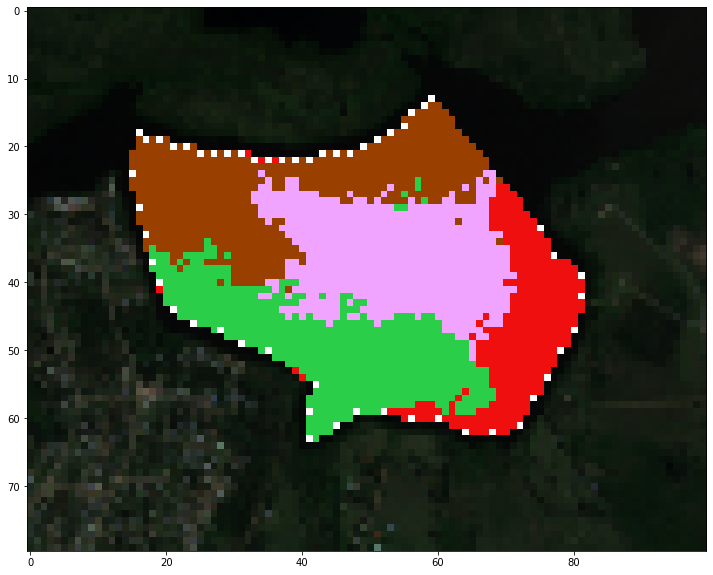

In [17]:
sample_day.rgb = clusters_image
sample_day.paint_coords(cisne_coords, (255, 255, 255), radius=0)
#draw_text("Water samples", sample_day.rgb, 50, 600, color=(255, 0, 0))
fig = plt.figure(figsize=(20,10))
plt.imshow(sample_day.rgb[480:560, 180:280,:])
#plt.savefig("clusters_and_samples.png", dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()

### Make pandas dataframe with mean and std of every cluster for every day

In [18]:
results_df = clustering_object.make_predictions_dataset()
#results_df.to_csv("../../data/final/kmeans_3/ndci_data.csv", index=False)
results_df

date  cluster_0_mean  cluster_0_max  cluster_0_min  cluster_1_mean  \
0   2017-11-19       -0.013499       0.032383      -0.059380       -0.033197   
1   2017-11-29       -0.020877       0.032813      -0.074568        0.005349   
2   2017-12-12        0.010882       0.066044      -0.044280        0.004137   
3   2017-12-29       -0.030240       0.043170      -0.103650       -0.041683   
4   2018-01-08       -0.019907       0.056210      -0.096025       -0.031637   
..         ...             ...            ...            ...             ...   
87  2021-02-06       -0.033672       0.035081      -0.102425       -0.043618   
88  2021-02-14       -0.025960       0.026335      -0.078255       -0.028511   
89  2021-02-19        0.016865       0.076999      -0.043268        0.004374   
90  2021-02-24        0.022187       0.092096      -0.047721        0.006165   
91  2021-02-26        0.050300       0.150208      -0.049609        0.025170   

    cluster_1_max  cluster_1_min  cluster_2_mean  cluster_2_max  \
0       -0.012407      -0.053987       -0.032990      -0.006380   
1        0.054607      -0.043909        0.005917       0.082300   
2        0.035938      -0.027663        0.010681       0.074871   
3        0.000049      -0.083415       -0.041994      -0.002581   
4        0.027151      -0.090425       -0.075692      -0.037818   
..            ...            ...             ...            ...   
87      -0.018714      -0.068521       -0.060067      -0.015299   
88       0.003449      -0.060472       -0.014743       0.024382   
89       0.034427      -0.025679        0.016895       0.053885   
90       0.047247      -0.034917        0.012849       0.058985   
91       0.073435      -0.023096        0.043101       0.104895   

    cluster_2_min  cluster_3_mean  cluster_3_max  cluster_3_min  
0       -0.059600       -0.029579      -0.000724      -0.058433  
1       -0.070465        0.005579       0.052716      -0.041558  
2       -0.053510        0.009891       0.041309      -0.021528  
3       -0.081407        0.002721       0.051504      -0.046063  
4       -0.113566       -0.017449       0.062283      -0.097181  
..            ...             ...            ...            ...  
87      -0.104835       -0.045614      -0.007372      -0.083856  
88      -0.053869       -0.021300       0.016523      -0.059123  
89      -0.020096        0.015267       0.055324      -0.024791  
90      -0.033288        0.013759       0.061841      -0.034324  
91      -0.018694        0.034208       0.096600      -0.028184  

[92 rows x 13 columns]

# NDCI clusters validation

## Cisnes

### Get Sentinel-2 data of same day as GT

In [88]:
cisnes_day_data = DayData(os.path.join(settings.processed_data_path, "2020-03-23", "MSI"))

### Perform clustering and obtain min, max and mean of every cluster in same day as GT

100%|██████████| 441288/441288 [00:00<00:00, 616802.30it/s]


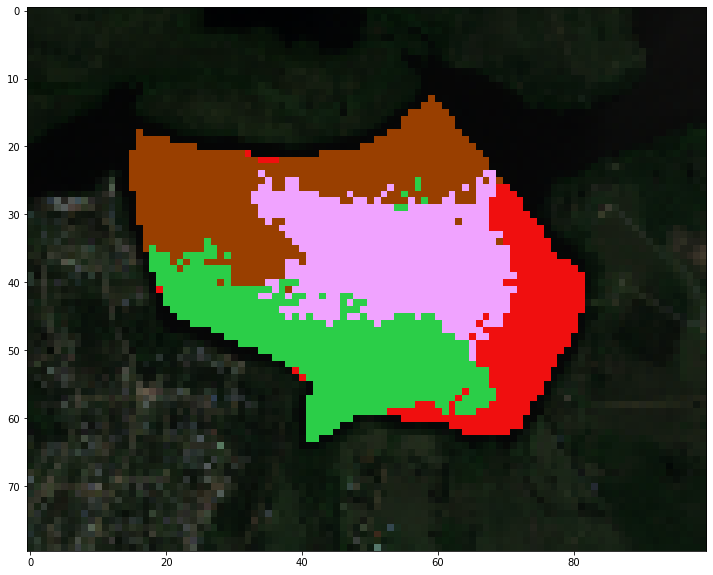

In [93]:
cisnes_clustering_object = ClusteringProcessing(data_generator, mask, clustering_algorithm="kmeans", k_clusters=4)
cisnes_clusters_image = cisnes_clustering_object.make_clusters_image()
cisnes_clusters_mask = cisnes_clustering_object.make_clusters_mask()

fig = plt.figure(figsize=(20,10))
plt.imshow(cisnes_clusters_image[480:560, 180:280, :])
plt.show()

In [90]:
all_days_clusters_data = cisnes_clustering_object.make_predictions_dataset()
results_df_cisnes_validation = all_days_clusters_data[all_days_clusters_data["date"] == datetime(2020, 3, 23).date()]
results_df_cisnes_validation

date  cluster_0_mean  cluster_0_max  cluster_0_min  cluster_1_mean  \
67  2020-03-23        0.246978       0.303856         0.1901        0.235632   

    cluster_1_max  cluster_1_min  cluster_2_mean  cluster_2_max  \
67       0.319209       0.152055        0.194899       0.269607   

    cluster_2_min  cluster_3_mean  cluster_3_max  cluster_3_min  
67       0.120192        0.250378        0.29897       0.201786

### Load GT data

In [91]:
atm_correction_gt_path = "../../data/final/2020-03-23/Laguna_Sauce_23-03-2020.csv"
CHL_TH = 10
gt_date = "2020-03-23"

atm_correction_gt_df_base = pd.read_csv(atm_correction_gt_path, index_col=False)
data_reformatted = []
measures = atm_correction_gt_df_base["measure"].values.tolist()
locations = atm_correction_gt_df_base.columns.tolist()[1:]
for location_name in atm_correction_gt_df_base.columns.tolist()[1:]:
    location_data_dict = {}
    for i, measure in enumerate(measures):
        location_data_dict[measure] = atm_correction_gt_df_base[location_name][i]
    location_data_dict["location"] = location_name
    data_reformatted.append(location_data_dict)
atm_correction_gt_df = pd.DataFrame(data_reformatted)
atm_correction_gt_df = atm_correction_gt_df[["Total chlorophyll concentration", "lat", "lon", "location"]]
atm_correction_gt_df = atm_correction_gt_df[atm_correction_gt_df["Total chlorophyll concentration"] > CHL_TH]

atm_correction_gt_df

Total chlorophyll concentration        lat        lon  location
0                             51.86 -34.841896 -55.124554     Sur 1
1                             54.91 -34.842670 -55.124363     Sur 2
2                             61.18 -34.843380 -55.123917     Sur 3
3                             64.12 -34.844120 -55.123917     Sur 4
4                             67.64 -34.844803 -55.123581     Sur 5
5                             74.78 -34.845470 -55.123329     Sur 6
7                             66.85 -34.846363 -55.120941     Sur 8
8                             61.59 -34.846363 -55.120941     Sur 9
9                             62.75 -34.846489 -55.120060    Sur 10
12                            75.28 -34.848778 -55.118721    Sur 13
13                            67.69 -34.848412 -55.117973    Sur 14
14                            66.98 -34.848007 -55.117233    Sur 15
15                            69.11 -34.848095 -55.116329    Sur 16
16                            73.88 -34.848179 -55.115429    Sur 17
17                            75.55 -34.848244 -55.114578    Sur 18
18                            66.37 -34.848476 -55.113739    Sur 19
19                            72.31 -34.848526 -55.112934    Sur 20
20                            70.01 -34.848301 -55.112099    Sur 21
21                            73.94 -34.847683 -55.111664    Sur 22
22                            69.19 -34.847027 -55.111271    Sur 23
23                            68.26 -34.846401 -55.110752    Sur 24
24                            67.44 -34.845741 -55.110382    Sur 25
25                            66.91 -34.844952 -55.110188    Sur 26
26                            72.80 -34.844261 -55.110210    Sur 27
27                            63.31 -34.843727 -55.110916    Sur 28
28                            69.59 -34.843151 -55.111576    Sur 29
29                            55.91 -34.840706 -55.124542   Norte 1
30                            75.55 -34.840874 -55.124161   Norte 2
31                            58.98 -34.840958 -55.123714   Norte 3
32                            59.26 -34.841045 -55.123295   Norte 4
33                            56.51 -34.841148 -55.122890   Norte 5
34                            56.41 -34.841213 -55.122463   Norte 6
35                            56.04 -34.841267 -55.122021   Norte 7
36                            56.77 -34.841263 -55.121574   Norte 8
37                            54.33 -34.841316 -55.121098   Norte 9
39                            57.57 -34.841373 -55.120228  Norte 11
40                            53.35 -34.841446 -55.119766  Norte 12
41                            55.05 -34.841412 -55.119339  Norte 13
42                            57.49 -34.841366 -55.118900  Norte 14
43                            58.65 -34.841270 -55.118450  Norte 15
44                            52.87 -34.841190 -55.117993  Norte 16
45                            55.37 -34.841217 -55.117546  Norte 17
46                            44.85 -34.841038 -55.117142  Norte 18
47                            44.27 -34.840878 -55.116745  Norte 19
48                            44.94 -34.840683 -55.116371  Norte 20
49                            41.72 -34.840454 -55.116020  Norte 21
50                            37.37 -34.840191 -55.115730  Norte 22
51                            34.96 -34.839989 -55.115360  Norte 23
52                            37.83 -34.839691 -55.115154  Norte 24

### Display sampling points on top of clusters

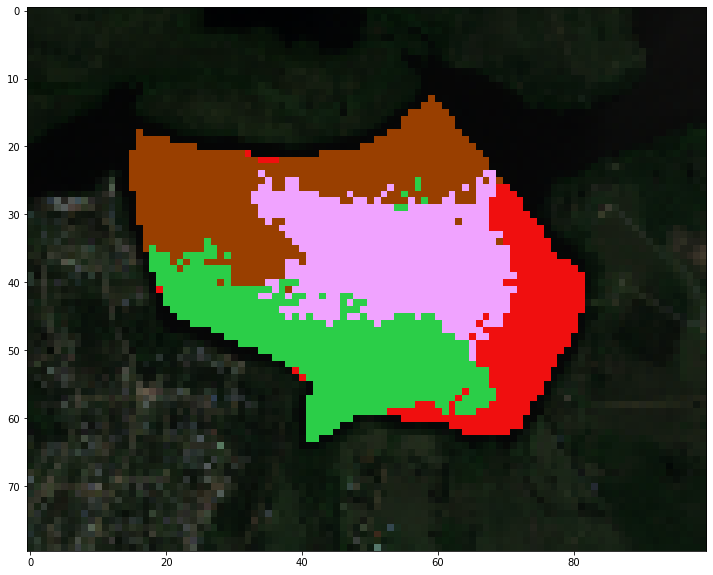

In [103]:
cisnes_coords = []
for index, row in atm_correction_gt_df.iterrows():
    gt_chl = row["Total chlorophyll concentration"]
    if gt_chl < 50:
        continue
    
    lat = row["lat"]
    lon = row["lon"]
    cisnes_coords.append((lat, lon))

cisnes_day_data.rgb = cisnes_clusters_image.copy()
#cisnes_day_data.paint_coords(cisnes_coords, (255, 255, 255), radius=0)
#draw_text("Water samples", sample_day.rgb, 50, 600, color=(255, 0, 0))
fig = plt.figure(figsize=(20,10))
plt.imshow(cisnes_day_data.rgb[480:560, 180:280, :])
#plt.savefig("clusters_and_samples.png", dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()

In [96]:
cisnes_chl_gt = []
cisnes_ndci_cluster_mean = []
cisnes_ndci_cluster_min = []
cisnes_ndci_cluster_max = []

for index, row in atm_correction_gt_df.iterrows():
    gt_chl = row["Total chlorophyll concentration"]
    if gt_chl < 50:
        continue
    cisnes_chl_gt.append(gt_chl)
    
    lat = row["lat"]
    lon = row["lon"]    
    location_y, location_x = cisnes_day_data.get_pos_index(lat, lon)
    
    cluster_idx = cisnes_clusters_mask[location_y, location_x]
    cluster_mean = results_df_cisnes_validation[f"cluster_{cluster_idx}_mean"].tolist()[0]
    cluster_min = results_df_cisnes_validation[f"cluster_{cluster_idx}_min"].tolist()[0]
    cluster_max = results_df_cisnes_validation[f"cluster_{cluster_idx}_max"].tolist()[0]
    
    cisnes_ndci_cluster_mean.append(cluster_mean)
    cisnes_ndci_cluster_min.append(cluster_min)
    cisnes_ndci_cluster_max.append(cluster_max)
    
all_preds_cisnes = {"Cluster Mean": cisnes_ndci_cluster_mean,
                    "Cluster Min": cisnes_ndci_cluster_min,
                    "Cluster Max": cisnes_ndci_cluster_max}

In [195]:
from scipy.stats import pearsonr
from scipy import stats
import math

def calculate_and_plot_correlations(title, gt, preds_dict, plot_liregress=False, 
                                    x_label='Total chlorophyll concentration (g/l)'):
    fig, axs = plt.subplots(math.ceil(len(preds_dict)/2), 2)
    fig.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(top=0.95)
    fig.set_size_inches(14.5, 14.5)
    for i, name_preds in enumerate(preds_dict.items()):
        name = name_preds[0]
        preds = name_preds[1]
        
        pearson_r = pearsonr(gt, preds)[0]
        slope, intercept, r_value, p_value, std_err = stats.linregress(gt, preds)
        
        fig.suptitle(title, fontsize=30)
        axs.reshape(-1)[i].scatter(gt, preds)
        if plot_liregress:
            axs.reshape(-1)[i].plot(gt, np.array(gt)*slope + intercept, 'k')
        axs.reshape(-1)[i].set_ylabel(name, fontsize=17)
        axs.reshape(-1)[i].set_xlabel(x_label, fontsize=17)
        axs.reshape(-1)[i].tick_params(axis='both', labelsize=16)
        axs.reshape(-1)[i].text(0.025, 0.95, f'$R^2={round(r_value**2, 2)}$', fontsize=17, transform=axs.reshape(-1)[i].transAxes)
        axs.reshape(-1)[i].text(0.025, 0.9, f'Pearson r = {round(pearson_r, 2)}', fontsize=17, transform=axs.reshape(-1)[i].transAxes)

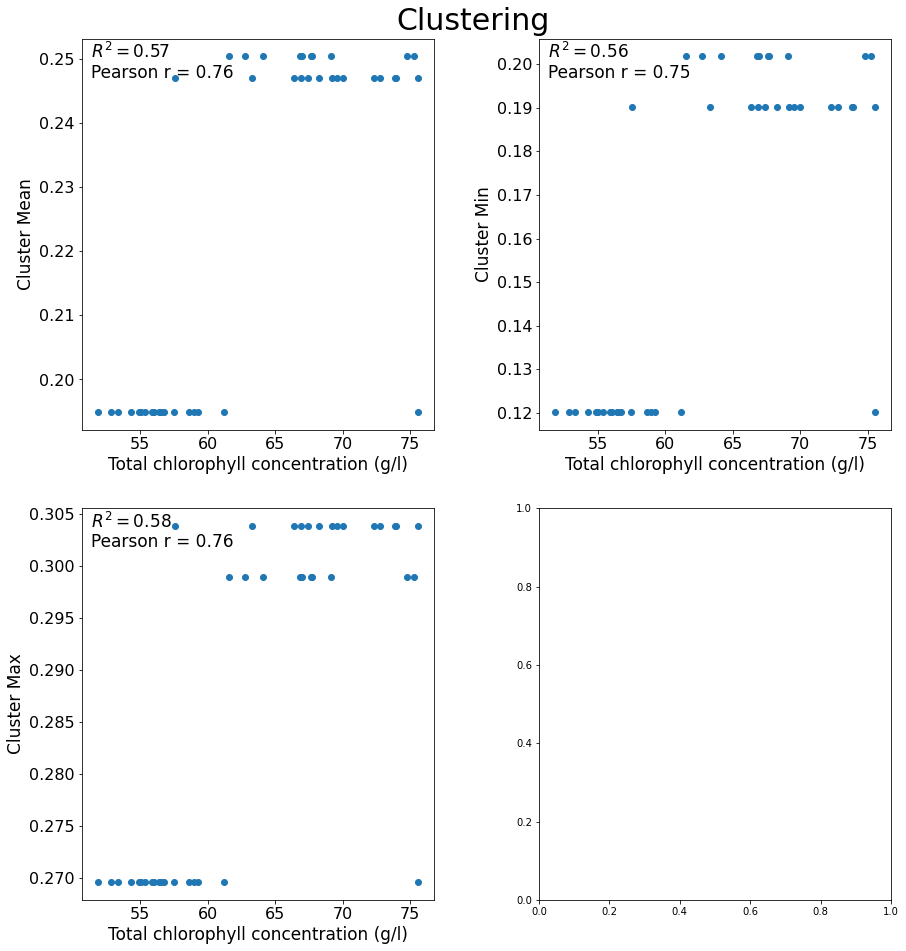

In [192]:
calculate_and_plot_correlations("Clustering", cisnes_chl_gt, all_preds_cisnes)

### Sauce

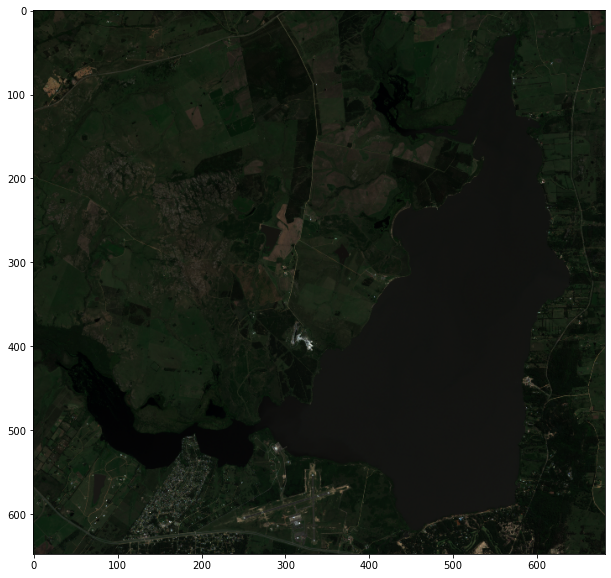

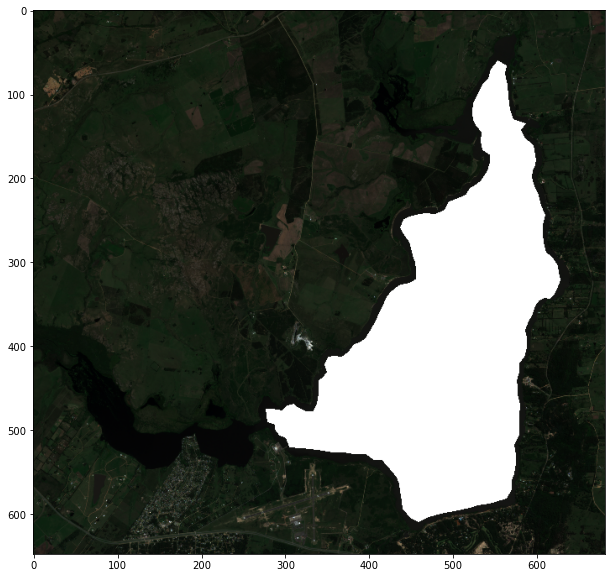

100%|██████████| 441288/441288 [00:01<00:00, 320035.31it/s]


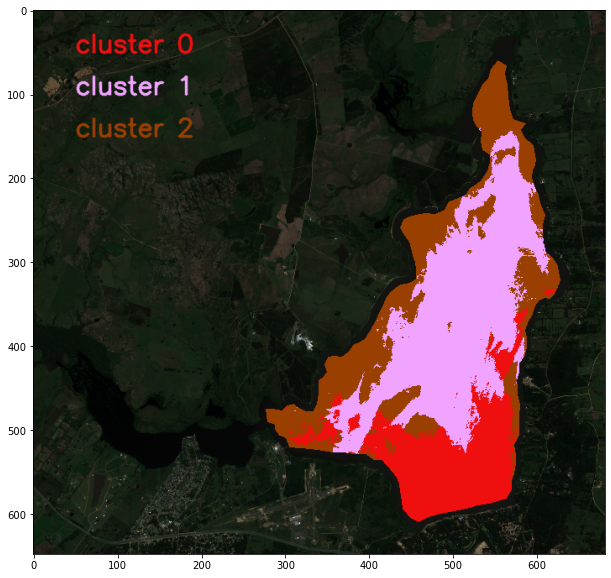

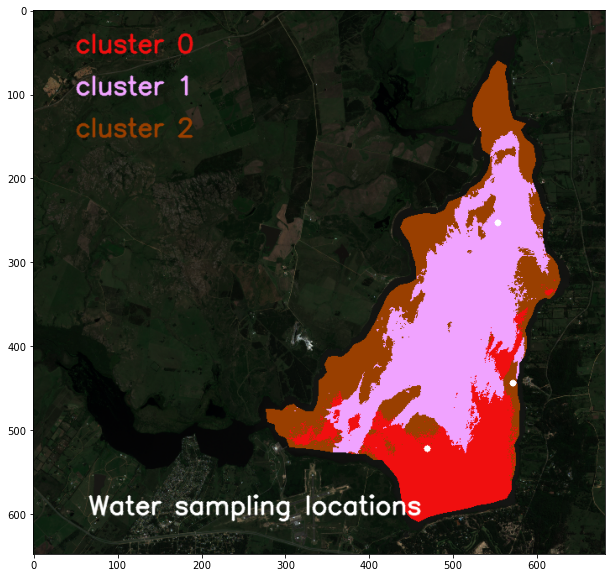

In [117]:
from clustering import ClusteringProcessing

sauce_sampling_points_coords = {
                              "SAUCE NORTE": [-34.795398, -55.047355],
                              "SAUCE SUR": [-34.844127, -55.064624],
                              "OSE": [-34.829670, -55.042758]
                         }

num_clusters = 3

sauce_sample_day = DayData(os.path.join(settings.processed_data_path, "2021-02-26", "MSI"))
fig = plt.figure(figsize=(20,10))
plt.imshow(sauce_sample_day.rgb)
plt.show()

sauce_mask = Mask("/home/enzo/Cyano_Detection/data/misc/water_masks/sauce")
fig = plt.figure(figsize=(20,10))
sauce_sample_with_mask = sauce_mask.display_mask_img(sauce_sample_day.rgb)
plt.imshow(sauce_sample_with_mask)
plt.show()

day_data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, PROCESSED_DATA_PATH, skip_invalid=True)
sauce_clustering_object = ClusteringProcessing(day_data_generator, sauce_mask, 
                                                clustering_algorithm="kmeans", k_clusters=num_clusters)
sauce_clusters_image = sauce_clustering_object.make_clusters_image()

fig = plt.figure(figsize=(20,10))
plt.imshow(sauce_clusters_image)
#plt.savefig("clusters_and_samples.png", dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()

sauce_sample_day.rgb = sauce_clusters_image
sauce_sample_day.paint_coords([coord for location, coord in sauce_sampling_points_coords.items()], (255, 255, 255), radius=4)
draw_text(" Water sampling locations", sauce_sample_day.rgb, 50, 600, color=(255, 255, 255))
fig = plt.figure(figsize=(20,10))
plt.imshow(sauce_sample_day.rgb)
#plt.savefig("clusters_and_samples.png", dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()

In [130]:
sauce_gt_path = os.path.join(settings.final_data_path, "algae_gt.csv")

sauce_gt_df = pd.read_csv(sauce_gt_path)
sauce_gt_df["date"] = pd.to_datetime(sauce_gt_df["date"])
sauce_gt_df["date"] = sauce_gt_df["date"].dt.date

sauce_gt_df = sauce_gt_df[sauce_gt_df["location"].isin(["SAUCE NORTE", "SAUCE SUR", "TA"])]
sauce_gt_df = sauce_gt_df.replace("TA", "OSE")
sauce_gt_df

date     location      fico    chl     label
2    2015-12-30  SAUCE NORTE   4282.50   7.50  No Bloom
3    2015-12-30    SAUCE SUR   5388.00   7.50  No Bloom
8    2016-01-07    SAUCE SUR  14982.50  12.25     Bloom
11   2016-01-07  SAUCE NORTE  11768.00  10.35     Bloom
14   2016-01-13  SAUCE NORTE  12766.00   9.70     Bloom
..          ...          ...       ...    ...       ...
685  2020-10-31          OSE   1083.00    NaN  No Bloom
686  2020-11-01          OSE     47.00    NaN  No Bloom
687  2020-11-02          OSE      5.96    NaN  No Bloom
688  2020-11-05          OSE      9.06    NaN  No Bloom
689  2021-02-04          OSE      1.77    NaN  No Bloom

[353 rows x 5 columns]

### Calculate  clusters correlations

Sampling locations frame position (y x)
{'SAUCE NORTE': (253, 553), 'SAUCE SUR': (522, 469), 'OSE': (444, 571)}
Sampling locations cluster index
{'SAUCE NORTE': 1, 'SAUCE SUR': 0, 'OSE': 2}


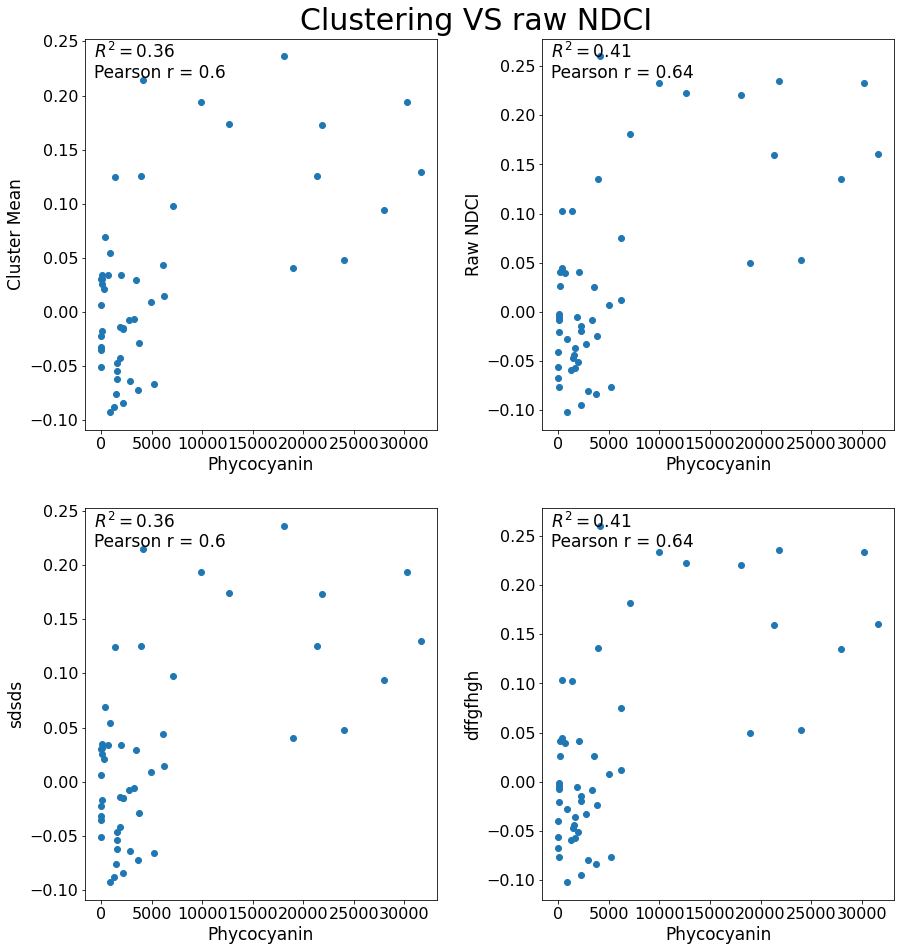

In [196]:
import math

sauce_clusters_mask = sauce_clustering_object.make_clusters_mask()

sauce_sampling_points_idxs = {location: sauce_sample_day.get_pos_index(coord[0], coord[1]) for location, coord in sauce_sampling_points_coords.items()}
print("Sampling locations frame position (y x)")
print(sauce_sampling_points_idxs)
sauce_sampling_points_clusters = {location: sauce_clusters_mask[idxs[0], idxs[1]]  for location, idxs in sauce_sampling_points_idxs.items()}
print("Sampling locations cluster index")
print(sauce_sampling_points_clusters)

sauce_ndci_array = sauce_clustering_object.ndci_dataset_array
sauce_ndci_array_dates = sauce_clustering_object.dataset["dates"]
sauce_clustering_ndci_dataset = sauce_clustering_object.make_predictions_dataset()
sauce_clustering_ndci_dataset["date"] = pd.to_datetime(sauce_clustering_ndci_dataset["date"])
sauce_clustering_ndci_dataset["date"] = sauce_clustering_ndci_dataset["date"].dt.date

sauce_gt_chls = []
sauce_gt_ficos = []
sauce_cluster_preds = []
sauce_ndci_preds = []
for index, row in sauce_gt_df.iterrows():
    gt_date = row["date"]
    gt_fico = row["fico"]
    gt_chl = row["chl"]
    gt_location = row["location"]
    
    # get cluster index of sampling location
    location_cluster = sauce_sampling_points_clusters[gt_location]
    # get cluster value of sampling location
    pred_cluster = sauce_clustering_ndci_dataset[sauce_clustering_ndci_dataset["date"] == gt_date][f"cluster_{location_cluster}_mean"]
    
    #if len(pred_cluster) > 0 and not math.isnan(float(gt_chl)):
    if len(pred_cluster) > 0:
        sauce_gt_chls.append(gt_chl)
        sauce_gt_ficos.append(gt_fico)
        
        sauce_cluster_preds.append(pred_cluster.tolist()[0])
        
        location_y, location_x = sauce_sampling_points_idxs[gt_location]
        day_idx = sauce_ndci_array_dates.index(gt_date)
        raw_ndci = sauce_ndci_array[location_y, location_x, day_idx]
        sauce_ndci_preds.append(raw_ndci)

all_preds_sauce = {"Cluster Mean": sauce_cluster_preds,
                   "Raw NDCI": sauce_ndci_preds,
                  "sdsds": sauce_cluster_preds,
                   "dffgfhgh": sauce_ndci_preds}

calculate_and_plot_correlations("Clustering VS raw NDCI", sauce_gt_ficos, all_preds_sauce, x_label="Phycocyanin")

### Calculate correlation of NDCI in sampling location

In [ ]:
from scipy.stats.stats import pearsonr

for location, idxs in sampling_points_idxs.items():    
    location_chl_gt = algae_df[algae_df["location"] == location]
    location_chl_gt.sort_values(by="date", inplace=True)
    
    common_dates = list(set(location_chl_gt.date.unique().tolist()) & set(clustering_object.dataset["dates"]))
    common_dates.sort()
    location_chl_gt = location_chl_gt[location_chl_gt["date"].isin(common_dates)]
    dates_idxs = [clustering_object.dataset["dates"].index(d) for d in common_dates]
    
    ndcis = [ndci_array[idxs[0], idxs[1], d_idx] for d_idx in dates_idxs]
    chls = location_chl_gt["chl"].tolist()
    
    print(location)
    correlation = pearsonr(ndcis, chls)[0]
    print(f"Correlation: {round(correlation, 3)}")

# Visualization

### Load data from https://www.ambiente.gub.uy/oan/datos-abiertos/calidad-agua/

In [ ]:
import csv

def load_cyano_concentration_csv(csv_path):
    agua_data = []
    with open(csv_path, newline='\n') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for i, row in enumerate(spamreader):
            day_measure = {} 
            if i==0:
                continue
            date_time = datetime.strptime(row[0][0:10], "%Y-%m-%d")
            day_measure["date"] = date_time
            
            cyano_value = row[2]
            day_measure["cyanobacteria"] = float(cyano_value)
            agua_data.append(day_measure)
    output = pd.DataFrame(agua_data)
    return output

agua_data = load_cyano_concentration_csv("../../data/final/agua_open_data(1).csv")
print(agua_data)

### Load data from Cisne measures and reformat it to:

| total chl | lat        | lon       | location |
|----------|------------|-----------|---------------|
| 54       | -34.842145 | -55.64641 | Sur 1         |

In [ ]:
chl_th = 10
cisne_df_base = pd.read_csv('Laguna_Sauce_24-03-2020.csv', index_col=False)
data_reformatted = []
measures = cisne_df_base["measure"].values.tolist()
locations = cisne_df_base.columns.tolist()[1:]
for location_name in cisne_df_base.columns.tolist()[1:]:
    location_data_dict = {}
    for i, measure in enumerate(measures):
        location_data_dict[measure] = cisne_df_base[location_name][i]
    location_data_dict["location"] = location_name
    data_reformatted.append(location_data_dict)
cisne_df = pd.DataFrame(data_reformatted)
cisne_df = cisne_df[["Total chlorophyll concentration", "lat", "lon", "location"]]
cisne_df = cisne_df[cisne_df["Total chlorophyll concentration"] > chl_th]

### Get correlations

In [ ]:
import random

day_date = "2020-03-23"
day_data = DayData(os.path.join(settings.data_path, day_date, "acolite_output"))
date_index = clustering_data["dates"].index("2020-03-23")
locations = []
gts = []
predicted = []
predicted_ndci = []
pbar = tqdm(total=len(cisne_df))
for index, row in cisne_df.iterrows():
    gt_chl = row["Total chlorophyll concentration"]
    
    lat = row["lat"]
    lon = row["lon"]
    location = row["location"]
    
    location_y, location_x = day_data.get_pos_index(lat, lon)
    
    cluster = cluster_map[location_y, location_x]
    while cluster == 80:
        offsets = [0, 1, -1]
        cluster = cluster_map[location_y + random.choice(offsets), location_x + random.choice(offsets)]
    try:
        cluster_mean = results_df[(results_df["date"] == "2020-03-23") & (results_df["cluster"] == cluster)]["mean_ndci"].values[0]
    except:
        pbar.update(1)
        continue
    day_data.rgb = cv2.circle(day_data.rgb, (location_x, location_y), 1, [255, 0, 255], -1)
    point_ndci = ndci_dataset_array[location_y, location_x, date_index]
    predicted_ndci.append(point_ndci)
    predicted.append(cluster_mean)
    gts.append(gt_chl)
    locations.append(location)
    pbar.update(1)
pbar.close()
day_data.show_rgb()

In [ ]:
fig = plt.figure(figsize=(40,20))
plt.grid()
ax1 = fig.add_subplot(111)
plt.yticks(fontsize=20)
ax1.plot(locations, gts)
ax1.set_ylabel('measured Chl', fontsize=20, color="b")
plt.xticks(fontsize=20, rotation=45)
ax2 = ax1.twinx()
plt.yticks(fontsize=20)
ax2.plot(locations, predicted, 'r-')
ax2.set_ylabel('NDCI mean in cluster', color='r', fontsize=20)
for tl in ax2.get_yticklabels():
    tl.set_color('r')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.show()
print(pearsonr(predicted, gts))
print(pearsonr(predicted_ndci, gts))

### Time series of NDCI mean

In [ ]:
day_indexes = range(1, len(results)+1)
fig = plt.figure(figsize=(40,20))
for label in results_df["cluster"].unique():
    #label_means = [d[label]["mean"] for d in results]
    ndci_means = results_df[results_df["cluster"] == label]["mean_ndci"].tolist()
    dates = results_df[results_df["cluster"] == label]["date"].values
    dates = [str(d)[0:10] for d in dates]
    #label_stds = [d[label]["std"] for d in results]
    #plt.plot(day_indexes, label_means, label=str(label) + " mean")
    #plt.plot([d["date"] for d in results], label_means, label=str(label))
    plt.plot(dates, ndci_means, label=str(label))
    #plt.plot(day_indexes, label_stds, label=str(label) + " std")
    
plt.xlabel('non cloudy days', fontsize=20)
plt.xticks(np.arange(0, len(ndci_means), 1.0), fontsize=14)
# Set the y axis label of the current axis.
plt.ylabel('cluster NDCI mean', fontsize=20)
plt.yticks(fontsize=20)
# Set a title of the current axes.
plt.title('Time series of NDCI mean for every cluster', fontsize=20)
# put date in angle to read better
fig.autofmt_xdate()
# show a legend on the plot
plt.legend(fontsize=20)
plt.grid()
# save figure
#plt.savefig("test3.png", dpi=100, bbox_inches='tight')
# Display a figure.
plt.show()
#plt.close(fig)

### Operations with satellite data and empiric data

In [ ]:
from scipy.stats.stats import pearsonr

for i in [0,1,2]:
    cluster_df = results_df[results_df["cluster"] == i]

    common_data_df = cluster_df.merge(agua_data, left_on='date', right_on='date')
    dates = common_data_df["date"].values
    dates = [str(d)[0:10] for d in dates]
    cyanobacteria = common_data_df["cyanobacteria"].values
    ndci_means = common_data_df["mean_ndci"].values
    fig = plt.figure(figsize=(40,20))
    plt.grid()
    ax1 = fig.add_subplot(111)
    ax1.plot(dates, ndci_means)
    ax1.set_ylabel('cluster ' + str(i) + ' ndci mean', fontsize=20, color="b")
    plt.xticks(fontsize=20, rotation=45)
    ax2 = ax1.twinx()
    ax2.plot(dates, cyanobacteria, 'r-')
    ax2.set_ylabel('cyanobacteria measure', color='r', fontsize=20)
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    plt.yticks(fontsize=20)
    plt.show()

    print(pearsonr(ndci_means, cyanobacteria))

### Time series of every cluster mean and std

In [ ]:
import matplotlib.pyplot as plt

for cluster_label in unique_labels:
    fig = plt.figure(figsize=(40,20))
    label_means = [d[cluster_label]["mean"] for d in results]
    label_stds = [d[cluster_label]["std"] for d in results]
    #plt.plot(day_indexes, label_means, label=str(label) + " mean")
    #plt.errorbar([d["date"] for d in results], label_means, label_stds, linestyle='None', marker='^')
    plt.errorbar([d["date"] for d in results], label_means, label_stds, marker='^', ecolor="red")
    #plt.plot([d["date"] for d in results], label_means, label=str(cluster_label))
    #plt.plot(day_indexes, label_stds, label=str(cluster_label) + " std")

    plt.xlabel('non cloudy days', fontsize=20)
    plt.xticks(np.arange(0, len(results), 1.0), fontsize=20)
    # Set the y axis label of the current axis.
    plt.ylabel('cluster NDCI mean', fontsize=20)
    # Set a title of the current axes.
    plt.title('Time series of NDCI mean for cluster ' + str(cluster_label), fontsize=20)
    # put date in angle to read better
    fig.autofmt_xdate()
    # show a legend on the plot
    plt.legend(fontsize=20)
    # save figure
    #plt.savefig("test3.png", dpi=100, bbox_inches='tight')
    # Display a figure.
    plt.show()
    #plt.close(fig)

### Compress directorys with results

In [ ]:
#!tar -zcvf K-means.tar.gz K-means
#!tar -zcvf Agglomerative.tar.gz Agglomerative_clustering
#!tar -zcvf Spectral.tar.gz Spectral